# 🎯 Problema de Negócio:

* A Vale S.A. (VALE3) é uma das principais empresas de mineração listadas na B3, com forte impacto no portfólio de investidores institucionais e pessoa física no Brasil. Para um gestor de investimentos ou analista de mercado, antecipar a trajetória do preço de fechamento (Close) e entender os padrões de volume de negociação é crucial para:

    1. Tomar decisões de compra/venda com melhor relação risco-retorno;

    2. Ajustar a alocação de ativos de curto a médio prazo;

    3. Desenvolver estratégias de trading baseadas em sinais estatísticos e de machine learning;

    4. Gerenciar o risco por meio de previsões confiáveis e métricas de incerteza.

* Objetivo Geral: Desenvolver um modelo preditivo de séries temporais para o preço de fechamento diário de VALE3, de modo a gerar forecasts de 7, 15 e 30 a dias futuros e embasar decisões de investimento.

* Importando as bibliotecas necessárias:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# 1. Coletando e Tratando os dados.

In [2]:
# Coletando dados da VALE3 e formatando o DataFrame:
vale = yf.download('VALE3.SA', start='2022-01-01', end='2025-06-01', multi_level_index=False)
vale = vale[['Close', 'Open', 'Volume']]
vale.reset_index(inplace=True)
vale['Date'] = pd.to_datetime(vale['Date'])
vale.set_index('Date', inplace=True)

# Criando um DataFrame para armazenar os dados do minério de ferro:
minerio_ferro = pd.read_csv(
    "Dados Históricos - Minério de ferro refinado 62% Fe CFR Futuros.csv"
    )
minerio_ferro.reset_index(inplace=True)
minerio_ferro['Data'] = pd.to_datetime(minerio_ferro['Data'], dayfirst=True)
minerio_ferro.set_index('Data', inplace=True)
minerio_ferro = minerio_ferro[['Último','Abertura', 'Var%']]
# invertendo a ordem das datas:
minerio_ferro = minerio_ferro.iloc[::-1]
minerio_ferro.rename(columns={
    'Último': 'Close',
    'Abertura': 'Open',
    'Var%': 'Variação'
}, inplace=True)

# Unindo os DataFrames de VALE3 e minério de ferro:
df = pd.merge(vale, minerio_ferro, left_index=True, right_index=True, suffixes=('_VALE3', '_Minerio'))
df.rename(columns={
    'Close_VALE3': 'Close_VALE3',
    'Open_VALE3': 'Open_VALE3',
    'Volume': 'Volume_VALE3',
    'Close_Minerio': 'Close_Minerio',
    'Open_Minerio': 'Open_Minerio',
    'Variação': 'Variação_Minerio'
}, inplace=True)

# Variação percentual do preço de fechamento da VALE3:
df['Variação_VALE3'] = df['Close_VALE3'].pct_change() * 100
# Trocando nan por 0%:
df['Variação_VALE3'].fillna(0, inplace=True)

# Vamos transformar as colunas Close_Minerio, Open_Minerio e Variação_Minerio em float:
df['Close_Minerio'] = df['Close_Minerio'].str.replace(',', '.', regex=False).astype(float)
df['Open_Minerio'] = df['Open_Minerio'].str.replace(',', '.', regex=False).astype(float)
df['Variação_Minerio'] = df['Variação_Minerio'].str.replace('%', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Variação percentual do preço de fechamento do minério de ferro:
df['Variação_Minerio'] = df['Close_Minerio'].pct_change() * 100 
# Trocando nan por 7,02%:
df['Variação_Minerio'].fillna(7.02, inplace=True)

df

[*********************100%***********************]  1 of 1 completed


,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Minerio,Open_Minerio,Variação_Minerio,Variação_VALE3
2022-01-03,57.766418,58.507014,18557200,120.40,120.40,7.020000,0.000000
2022-01-04,57.085072,58.144123,18178700,120.91,120.91,0.423588,-1.179486
2022-01-05,57.625706,57.299848,22039000,124.14,124.14,2.671408,0.947067
2022-01-06,58.788437,58.240398,22044100,125.94,125.94,1.449976,2.017730
2022-01-07,62.209991,59.543850,35213100,126.21,126.21,0.214388,5.820115
...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.000000,14747300,99.81,99.81,-0.080088,0.165960
2025-05-27,53.840000,54.000000,17943000,99.48,99.48,-0.330628,-0.883652
2025-05-28,53.410000,53.740002,17700600,99.39,99.39,-0.090470,-0.798663
2025-05-29,53.450001,53.730000,10246100,99.27,99.27,-0.120736,0.074894


# 2. Adicionando fetures temporais ao nosso DataFrame.

In [3]:
# Vamos adicionar as fetures de dias, semanas, meses, anos e calcular o seno e o cosseno do mês para capturar sazonalidade cíclica:
df['Dia'] = df.index.day
df['Semana'] = df.index.weekday
df['Mês'] = df.index.month
df['Ano'] = df.index.year

df['Sin_Mês'] = np.sin(2 * np.pi * df['Mês'] / 12)
df['Cos_Mês'] = np.cos(2 * np.pi * df['Mês'] / 12)

# Vamos adicionar médias móveis de 20 e 200 dias no preço de fechamento da VALE3 e do minério de ferro:
df['MM_20D_VALE3'] = df['Close_VALE3'].rolling(window=20, min_periods=1).mean()
df['MM_200D_VALE3'] = df['Close_VALE3'].rolling(window=200, min_periods=1).mean()
df['MM_20D_MF'] = df['Close_Minerio'].rolling(window=20, min_periods=1).mean()
df['MM_200D_MF'] = df['Close_Minerio'].rolling(window=200, min_periods=1).mean()

# Coluna do preço anterior(D-1):
df['Close_VALE3_D-1'] = df['Close_VALE3'].shift(1)
df['Close_VALE3_D-1'].fillna(0, inplace=True)

df

,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Minerio,Open_Minerio,Variação_Minerio,Variação_VALE3,Dia,Semana,Mês,Ano,Sin_Mês,Cos_Mês,MM_20D_VALE3,MM_200D_VALE3,MM_20D_MF,MM_200D_MF,Close_VALE3_D-1
2022-01-03,57.766418,58.507014,18557200,120.40,120.40,7.020000,0.000000,3,0,1,2022,0.5,0.866025,57.766418,57.766418,120.400000,120.400000,0.000000
2022-01-04,57.085072,58.144123,18178700,120.91,120.91,0.423588,-1.179486,4,1,1,2022,0.5,0.866025,57.425745,57.425745,120.655000,120.655000,57.766418
2022-01-05,57.625706,57.299848,22039000,124.14,124.14,2.671408,0.947067,5,2,1,2022,0.5,0.866025,57.492399,57.492399,121.816667,121.816667,57.085072
2022-01-06,58.788437,58.240398,22044100,125.94,125.94,1.449976,2.017730,6,3,1,2022,0.5,0.866025,57.816408,57.816408,122.847500,122.847500,57.625706
2022-01-07,62.209991,59.543850,35213100,126.21,126.21,0.214388,5.820115,7,4,1,2022,0.5,0.866025,58.695125,58.695125,123.520000,123.520000,58.788437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.000000,14747300,99.81,99.81,-0.080088,0.165960,23,4,5,2025,0.5,-0.866025,54.055500,54.977746,99.505000,101.648300,54.230000
2025-05-27,53.840000,54.000000,17943000,99.48,99.48,-0.330628,-0.883652,27,1,5,2025,0.5,-0.866025,54.055000,54.964091,99.483000,101.611400,54.320000
2025-05-28,53.410000,53.740002,17700600,99.39,99.39,-0.090470,-0.798663,28,2,5,2025,0.5,-0.866025,54.023500,54.947779,99.457000,101.575400,53.840000
2025-05-29,53.450001,53.730000,10246100,99.27,99.27,-0.120736,0.074894,29,3,5,2025,0.5,-0.866025,54.004000,54.937926,99.427500,101.540500,53.410000


# 3. Decomposição da série temporal (tendência, sazonalidade e resíduo).

In [4]:
decomposicao = seasonal_decompose(df['Close_VALE3'], model='multiplicative', period=30)
df['Tendencia'] = decomposicao.trend
df['Sazonalidade'] = decomposicao.seasonal
df['Residuo'] = decomposicao.resid

# Preencher valores ausentes resultantes da decomposição:
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)

# 4. Lags e Rolling Statistics.

* Vamos criar colunas que trazem o preço de fechamento e o retorno percentual de ontem, anteontem, etc. Assim o modelo “vê” vários dias anteriores:

In [5]:
lags = [1, 2, 3, 4, 5] # dias de atraso

for lag in lags:
    df[f'Close_Vale_lag{lag}'] = df['Close_VALE3'].shift(lag) # Preço do fechamento lagado
    df[f'Ret_Vale_lag{lag}'] = df['Close_VALE3'].shift(lag) # Retorno percentual lagado

* Agora, para captar tendências e volatilidade de curto e médio prazo, vamos criar médias móveis de curto prazo e estatísticas móveis (desvio, assimetria, curtose) em janelas de vários tamanhos:

In [6]:
windows = [5, 10, 15, 30, 50] # Janelas de dias

for w in windows:
    # Média móvel
    df[f'MM_de_{w}'] = df['Close_VALE3'].rolling(window=w, min_periods=1).mean()
    # Desvio-padrão móvel dos retornos em w dias
    df[f'Desvio_Padrao_de_{w}'] = df['Close_VALE3'].rolling(window=w, min_periods=1).std()
    # Assimetria móvel dos retornos
    df[f'roll_skew_{w}'] = df['Close_VALE3'].rolling(window=w, min_periods=1).skew()
    # Curtose móvel dos retornos
    df[f'Curtose_{w}'] = df['Close_VALE3'].rolling(window=w, min_periods=1).kurt()

In [7]:
# Dropando valores NaN:
df = df.dropna()
df

,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Minerio,Open_Minerio,Variação_Minerio,Variação_VALE3,Dia,Semana,Mês,...,roll_skew_15,Curtose_15,MM_de_30,Desvio_Padrao_de_30,roll_skew_30,Curtose_30,MM_de_50,Desvio_Padrao_de_50,roll_skew_50,Curtose_50
2022-01-10,61.469383,61.091678,25056700,124.48,124.48,-1.370731,-1.190497,10,0,1,...,0.758626,-1.666751,59.157501,2.162183,0.758626,-1.666751,59.157501,2.162183,0.758626,-1.666751
2022-01-11,62.639523,61.824869,28418800,126.75,126.75,1.823586,1.903613,11,1,1,...,0.288820,-2.355135,59.654933,2.372326,0.288820,-2.355135,59.654933,2.372326,0.288820,-2.355135
2022-01-12,63.320877,64.054065,27335400,128.66,128.66,1.506903,1.087739,12,2,1,...,0.027981,-2.264994,60.113176,2.550261,0.027981,-2.264994,60.113176,2.550261,0.027981,-2.264994
2022-01-13,62.358101,62.832081,23154200,127.84,127.84,-0.637339,-1.520472,13,3,1,...,-0.244852,-2.134049,60.362612,2.500164,-0.244852,-2.134049,60.362612,2.500164,-0.244852,-2.134049
2022-01-14,62.720997,62.002619,21183400,126.24,126.24,-1.251564,0.581955,14,4,1,...,-0.457190,-1.914942,60.598450,2.472343,-0.457190,-1.914942,60.598450,2.472343,-0.457190,-1.914942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.000000,14747300,99.81,99.81,-0.080088,0.165960,23,4,5,...,-0.324580,-1.637176,53.886667,1.031050,0.026033,-1.077892,54.707800,1.957700,-0.092500,-0.233223
2025-05-27,53.840000,54.000000,17943000,99.48,99.48,-0.330628,-0.883652,27,1,5,...,-0.414413,-1.341707,53.953000,0.956845,0.165655,-1.250139,54.709400,1.956942,-0.094601,-0.228681
2025-05-28,53.410000,53.740002,17700600,99.39,99.39,-0.090470,-0.798663,28,2,5,...,-0.421093,-1.216086,53.974000,0.936919,0.169704,-1.187451,54.687600,1.965375,-0.064842,-0.278782
2025-05-29,53.450001,53.730000,10246100,99.27,99.27,-0.120736,0.074894,29,3,5,...,-0.394918,-1.104977,53.967000,0.940125,0.186887,-1.207078,54.630800,1.959149,0.008174,-0.252883


# 5. Indicadores Técnicos.

* Média Móvel Exponencial:

In [8]:
# Média móvel exponencial de 20 dias:
df['MME_20D'] = df['Close_VALE3'].ewm(span=20, adjust=False).mean()
# Média móvel exponencial de 200 dias:
df['MME_200D'] = df['Close_VALE3'].ewm(span=200, adjust=False).mean()

* RSI (Relative Strength Index):

In [9]:
def calculo_rsi(series, window=14):
    delta = series.diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

df['RSI_14'] = calculo_rsi(df['Close_VALE3'], window=14)
df['RSI_14'].fillna(df['RSI_14'].mean(), inplace=True)
df[['RSI_14']]

,RSI_14
2022-01-10,49.585509
2022-01-11,49.585509
2022-01-12,49.585509
2022-01-13,49.585509
2022-01-14,49.585509
...,...
2025-05-23,63.709707
2025-05-27,57.777793
2025-05-28,54.450253
2025-05-29,56.327985


* MACD:

In [10]:
MME_12 = df['Close_VALE3'].ewm(span=12, adjust=False).mean()
MME_26 = df['Close_VALE3'].ewm(span=26, adjust=False).mean()

df['MACD'] = MME_12 - MME_26

df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

* Bollinger Bands:

In [11]:
# Calculando a média móvel e o desvio padrão
media_20 = df['Close_VALE3'].rolling(window=20, min_periods=1).mean()
desvio_20 = df['Close_VALE3'].rolling(window=20, min_periods=1).std()

# Calculando as bandas
df['Banda_Media'] = media_20
df['Banda_Superior'] = media_20 + (2 * desvio_20)
df['Banda_Inferior'] = media_20 - (2 * desvio_20)

df['Banda_Inferior'].fillna(df['Banda_Inferior'].mean(), inplace=True)
df['Banda_Superior'].fillna(df['Banda_Superior'].mean(), inplace=True)
df[['Banda_Media', 'Banda_Superior', 'Banda_Inferior']]

,Banda_Media,Banda_Superior,Banda_Inferior
2022-01-10,61.469383,63.620484,56.135745
2022-01-11,62.054453,63.709280,60.399626
2022-01-12,62.476594,64.349471,60.603718
2022-01-13,62.446971,63.980752,60.913190
2022-01-14,62.501776,63.852493,61.151059
...,...,...,...
2025-05-23,54.055500,56.080205,52.030795
2025-05-27,54.055000,56.079923,52.030077
2025-05-28,54.023500,56.068903,51.978097
2025-05-29,54.004000,56.064152,51.943848


# 6. Volatilidade e Risco.

In [12]:
# Retorno logarítmico diário:
df['LogRet'] = np.log(df['Close_VALE3'] / df['Close_VALE3'].shift(1))

# Volatilidade histórica em janelas móveis:
window = 30
df[f'Volatilidade_{window}'] = df['LogRet'].rolling(window=window, min_periods=1).std() * np.sqrt(252)

# Tratando valores NaN:
df['Volatilidade_30'].fillna(0, inplace=True)
df['LogRet'].fillna(0, inplace=True)

df[['LogRet','Volatilidade_30']]

,LogRet,Volatilidade_30
2022-01-10,0.000000,0.000000
2022-01-11,0.018857,0.000000
2022-01-12,0.010819,0.090233
2022-01-13,-0.015321,0.283684
2022-01-14,0.005803,0.231768
...,...,...
2025-05-23,0.001658,0.245252
2025-05-27,-0.008876,0.198358
2025-05-28,-0.008019,0.193722
2025-05-29,0.000749,0.187599


* Rolling Sharpe Ratio:

In [13]:
# taxa livre de risco anual de 3% convertida para diária:
rf_daily = 0.03 / 252
window = 30

# Retorno excedente ao RF:
df['ExcessRet'] = df['LogRet'] - rf_daily

# Rolling mean e rolling std do excesso:
roll_mean_ex = df['ExcessRet'].rolling(window=window, min_periods=1).mean()
roll_std_ex = df['ExcessRet'].rolling(window=window, min_periods=1).std()

# Rolling Sharpe:
df[f'Sharpe_{window}d'] = roll_mean_ex / roll_std_ex

df['Sharpe_30d'].fillna(0, inplace=True)

df[['ExcessRet', 'Sharpe_30d']]

,ExcessRet,Sharpe_30d
2022-01-10,-0.000119,0.000000
2022-01-11,0.018738,0.698179
2022-01-12,0.010700,1.032782
2022-01-13,-0.015441,0.234651
2022-01-14,0.005684,0.304624
...,...,...
2025-05-23,0.001539,0.205892
2025-05-27,-0.008995,0.090941
2025-05-28,-0.008138,0.022656
2025-05-29,0.000630,-0.021134


# 7. Interações e Razões.

* 7.1. Razão entre os preços de fechamento:

In [14]:
df['Ratio_VALE3_Minerio'] = df['Close_VALE3'] / df['Close_Minerio']

* 7.2. Diferença absoluta entre os preços de fechamento:

In [15]:
df['Diff_VALE3_Minerio'] = df['Close_VALE3'] - df['Close_Minerio']

* 7.3. Diferença entre as variações percentuais:

In [16]:
df['Diff_Retorno_VALE3_Minerio'] = df['Variação_VALE3'] - df['Variação_Minerio']

# 8. Pré-seleção e Redução de Dimensionalidade.

* Esse passo garante que iremos manter apenas as variáveis que agregam valor preditivo ao modelo, evitando:

    1. Multicolinearidade entre variáveis;

    2. Variáveis irrelevantes;

    3. Overfitting.

In [17]:
# Primeiro criamos uma variável-alvo, nesse caso vamos pegar o preço do fechamento do dia seguinte:
df['Target_Close_D+1'] = df['Close_VALE3'].shift(-1)
df['Target_Close_D+1'].fillna(0, inplace=True)

# Agora vamos calcular a correlação de todas as colunas númericas com essa target:
correlacoes = df.corr(numeric_only=True)['Target_Close_D+1'].sort_values(ascending=False)

# Seleciona só variáveis numéricas:
X_numerico = df.select_dtypes(include=[np.number]).drop(columns=['Target_Close_D+1'])

# Aplica filtro de variância com um limiar suave:
selector = VarianceThreshold(threshold=1e-5)
selector.fit(X_numerico)
x_filtrado_var = X_numerico.loc[:, selector.get_support()]

# Matriz de correlação:
corr_matriz = x_filtrado_var.corr().abs()

# Triângulo superior:
upper = corr_matriz.where(np.triu(np.ones(corr_matriz.shape), k=1).astype(bool))

# Identifica colunas muito correlacionadas (threshold de 0.95 para maior tolerância:
colunas_a_remover = [col for col in upper.columns if any(upper[col] > 0.95)]

# Remove do conjunto:
x_filtrado_corr = x_filtrado_var.drop(columns=colunas_a_remover)

# Junta com a target temporariamente
x_filtrado_corr['Target_Close_D+1'] = df['Target_Close_D+1']

# Calcula a correlação com a variável alvo
correlacoes = x_filtrado_corr.corr()['Target_Close_D+1'].abs().sort_values(ascending=False)

# Seleciona top 25 variáveis mais correlacionadas com o target
top_features = correlacoes.drop('Target_Close_D+1').head(25).index.to_list()

# Conjunto final
df_final = df[top_features + ['Target_Close_D+1']]

# Tratando um valor ausente:
df_final.fillna(0, inplace=True)

df_final

,Close_VALE3,MM_20D_VALE3,Banda_Inferior,Close_Minerio,MME_200D,Desvio_Padrao_de_50,MM_20D_MF,MACD,Ano,MM_200D_VALE3,...,Cos_Mês,RSI_14,Diff_VALE3_Minerio,Desvio_Padrao_de_10,Desvio_Padrao_de_5,Volatilidade_30,Ratio_VALE3_Minerio,Mês,Variação_Minerio,Target_Close_D+1
2022-01-10,61.469383,59.157501,56.135745,124.48,61.469383,2.162183,123.680000,0.000000,2022,59.157501,...,0.866025,49.585509,-63.010617,2.162183,2.294180,0.000000,0.493809,1,-1.370731,62.639523
2022-01-11,62.639523,59.654933,60.399626,126.75,61.481026,2.372326,124.118571,0.093344,2022,59.654933,...,0.866025,49.585509,-64.110477,2.372326,2.214807,0.000000,0.494197,1,1.823586,63.320877
2022-01-12,63.320877,60.113176,60.603718,128.66,61.499333,2.550261,124.686250,0.219767,2022,60.113176,...,0.866025,49.585509,-65.339123,2.550261,1.753524,0.090233,0.492157,1,1.506903,62.358101
2022-01-13,62.358101,60.362612,60.913190,127.84,61.507878,2.500164,125.036667,0.239509,2022,60.362612,...,0.866025,49.585509,-65.481899,2.500164,0.672549,0.283684,0.487782,1,-0.637339,62.720997
2022-01-14,62.720997,60.598450,61.151059,126.24,61.519949,2.472343,125.157000,0.281195,2022,60.598450,...,0.866025,49.585509,-63.519003,2.472343,0.675358,0.231768,0.496839,1,-1.251564,63.920761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.055500,52.030795,99.81,55.085497,1.957700,99.505000,0.198816,2025,54.977746,...,-0.866025,63.709707,-45.490000,0.511426,0.541322,0.245252,0.544234,5,-0.080088,53.840000
2025-05-27,53.840000,54.055000,52.030077,99.48,55.073104,1.956942,99.483000,0.130217,2025,54.964091,...,-0.866025,57.777793,-45.640000,0.585834,0.565711,0.198358,0.541214,5,-0.330628,53.410000
2025-05-28,53.410000,54.023500,51.978097,99.39,55.056555,1.965375,99.457000,0.040685,2025,54.947779,...,-0.866025,54.450253,-45.980000,0.732667,0.474310,0.193722,0.537378,5,-0.090470,53.450001
2025-05-29,53.450001,54.004000,51.943848,99.27,55.040570,1.959149,99.427500,-0.026733,2025,54.937926,...,-0.866025,56.327985,-45.819999,0.825615,0.423969,0.187599,0.538431,5,-0.120736,52.099998


# 9. Modelo Híbrido(LSTM + Prophet + XGBoost).

In [18]:
# Vamos criar targets temporais, para termos multi-horizonte de D+7, D+15 e D+30:
horizons = [7, 15, 30]
for h in horizons:
    df_final[f'Target_{h}D'] = df_final['Close_VALE3'].shift(-h)

# Vamos remover os valores NaN:
df_final = df_final.dropna()

# Divisão temporal (80% treino, 20% teste):
train_size = int(0.8 * len(df_final))
train = df_final.iloc[:train_size]
test = df_final.iloc[train_size:]

# Separar fetures e targets:
X_train = train.drop(columns=[f'Target_{h}D' for h in horizons])
y_train = train[[f'Target_{h}D' for h in horizons]]
X_test = test.drop(columns=[f'Target_{h}D' for h in horizons])
y_test = test[[f'Target_{h}D' for h in horizons]]

# Normaçização para o LSTM:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

* Modelo LSTM:

In [19]:
# Reshape para formato 3D [samples, timesteps, features]:
timesteps = 30
X_train_lstm = np.array([X_train_scaled[i-timesteps:i] for i in range(timesteps, len(X_train_scaled))])
X_test_lstm = np.array([X_test_scaled[i-timesteps:i] for i in range(timesteps, len(X_test_scaled))])

# Criando modelo LSTM:
modelo_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(timesteps, X_train_scaled.
                                                  shape[1])),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(len(horizons))
])

modelo_lstm.compile(optimizer='adam', loss='mse')
modelo_lstm.fit(X_train_lstm, y_train.iloc[timesteps:],
                epochs=100, batch_size=32,
               validation_split=0.1, verbose=1)

# Fazendo previsões:
lstm_preds = modelo_lstm.predict(X_test_lstm)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3727.3125 - val_loss: 2892.5457
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3255.4241 - val_loss: 1999.1112
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2294.3811 - val_loss: 1212.0929
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1407.8278 - val_loss: 548.3544
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 699.2917 - val_loss: 139.4261
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 257.1386 - val_loss: 11.3292
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 69.2970 - val_loss: 21.3323
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 42.8188 - val_loss: 35.2846
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 39.8496 - val_loss: 32.4938
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 41.4142 - val_loss: 30.6380
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 43.4287 - val_loss: 28.4847
Epoch 12/100

* Modelo Prophet: 

In [24]:
# Preparar dados para o Prophet
prophet_train = train.reset_index()[['index', 'Close_VALE3']].rename(
    columns={'index': 'ds', 'Close_VALE3': 'y'})

# Adicionar regressores
for feature in ['Close_Minerio', 'RSI_14', 'Volatilidade_30']:
    prophet_train[feature] =  train[feature].values

# Criar e treinar o modelo
modelo_prophet = Prophet()
for feature in ['Close_Minerio', 'RSI_14', 'Volatilidade_30']:
    modelo_prophet.add_regressor(feature)

modelo_prophet.fit(prophet_train)

prophet_train_preds = modelo_prophet.predict(prophet_train)['yhat'].values

18:49:18 - cmdstanpy - INFO - Chain [1] start processing
18:49:20 - cmdstanpy - INFO - Chain [1] done processing


* Modelo Prophet para previsão de teste:

In [34]:
# depois de fitar o Prophet:
futuro = modelo_prophet.make_future_dataframe(
    periods=len(test), include_history=False
)
# preencha futuramente seus regressores:
for feat in ['Close_Minerio','RSI_14','Volatilidade_30']:
    futuro[feat] = test[feat].values

# agora sim, predições sobre o TESTE
prophet_test_preds = modelo_prophet.predict(futuro)['yhat'].values


* Modelo XGBoost:

In [22]:
# Treinar o XGBoost:
modelo_xgb = MultiOutputRegressor(
    XGBRegressor(n_estimators=1500, learning_rate=0.05, max_depth=6)
)
modelo_xgb.fit(X_train, y_train)

# Fazendo as previsões:
xgb_preds = modelo_xgb.predict(X_test)

* Camada de combinação(Ensemble):

In [35]:
start_idx = timesteps
start = timesteps

# ALINHANDO TODOS OS VETORES:

# LSTM já vem sem os primeiros timesteps
lstm_aligned    = lstm_preds          # shape = (n_test–timesteps, 3)

# Prophet precisa pular o mesmo offset
prophet_aligned = prophet_test_preds[start:]  # shape = (n_test–timesteps,)

# XGB também:
xgb_all         = modelo_xgb.predict(X_test)  # shape = (n_test, 3)
xgb_aligned     = xgb_all[start:]             # shape = (n_test–timesteps, 3)

# Preparar dados de TREINO para cada horizonte
ensemble_train = np.column_stack([
    modelo_lstm.predict(X_train_lstm),            # (n_train_samples, 3)
    prophet_train_preds[start_idx:].reshape(-1, 1),  # (n_train_samples, 1)
    modelo_xgb.predict(X_train.iloc[start_idx:])  # (n_train_samples, 3)
])

# Criar e treinar meta-modelos (um para cada horizonte)
meta_models = []
for i in range(len(horizons)):
    meta_model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05)
    
    # Selecionar apenas as colunas relevantes para cada horizonte
    ensemble_train_horizon = np.column_stack([
        ensemble_train[:, i],                      # LSTM para horizonte i
        ensemble_train[:, -3],                     # Prophet (está na última posição)
        ensemble_train[:, len(horizons)+i]         # XGBoost para horizonte i
    ])
    
    meta_model.fit(ensemble_train_horizon, y_train.iloc[start_idx:, i])
    meta_models.append(meta_model)

ensemble_test = np.column_stack([
    lstm_aligned,                      # (n_test–timesteps, 3)
    prophet_aligned.reshape(-1,1),     # (n_test–timesteps, 1)
    xgb_aligned                        # (n_test–timesteps, 3)
])

# Fazer previsões para cada horizonte
final_preds = []
for i in range(len(horizons)):
    horizon_test = np.column_stack([
        ensemble_test[:, i],                # LSTM_i
        ensemble_test[:, len(horizons)],    # Prophet (sempre na coluna idx=3)
        ensemble_test[:, len(horizons)+1+i] # XGB_i (colunas 4,5,6)
    ])
    final_preds.append(meta_models[i].predict(horizon_test))

final_preds = np.column_stack(final_preds)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


* Avaliação do modelo:

In [37]:
# Calcular métricas para cada horizonte
results = {}
for i, horizon in enumerate(horizons):
    actual = y_test.iloc[timesteps:][f'Target_{horizon}D']
    predicted = final_preds[:, i]
    
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    
    # Calcular acurácia direcional
    direction_correct = np.sign(actual.values - X_test['Close_VALE3'].iloc[timesteps:]) == \
                       np.sign(predicted - X_test['Close_VALE3'].iloc[timesteps:])
    dir_acc = np.mean(direction_correct) * 100
    
    results[f'{horizon} dias'] = {'MAE': mae, 'MAPE': mape, 'Direction Accuracy': dir_acc}

# Exibir resultados em DataFrame
results_df = pd.DataFrame(results).T
display(results_df)

,MAE,MAPE,Direction Accuracy
7 dias,13.781776,25.612904,49.21875
15 dias,5.113786,9.583647,56.25000
30 dias,5.819504,11.042085,48.43750


* Visualizando as previsões:

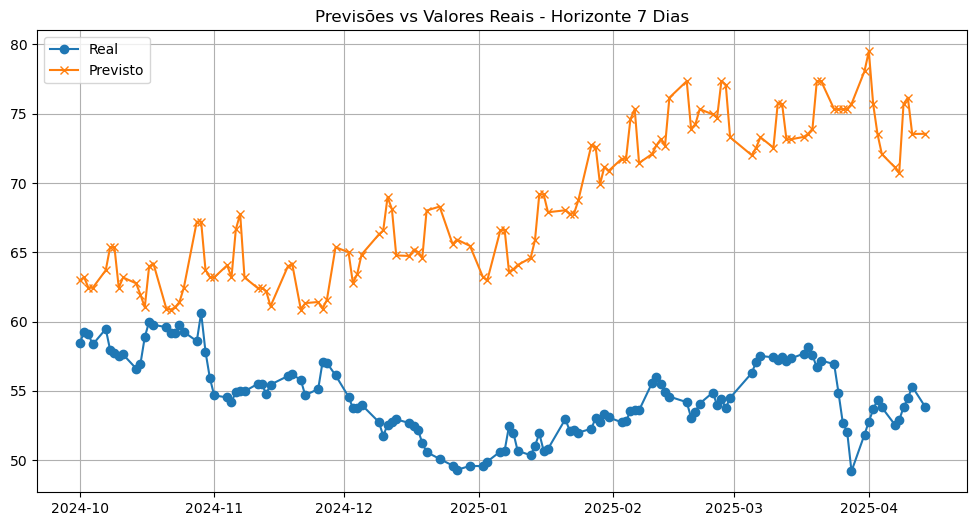

In [38]:

# Plotar previsões vs real para horizonte de 7 dias
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[timesteps:], y_test['Target_7D'].iloc[timesteps:], label='Real', marker='o')
plt.plot(y_test.index[timesteps:], final_preds[:, 0], label='Previsto', marker='x')
plt.title('Previsões vs Valores Reais - Horizonte 7 Dias')
plt.legend()
plt.grid(True)
plt.show()